In [1]:
import matplotlib.pyplot as plt
import numpy as np
from imp import reload

import neuropacks
from neuropacks import Allen
from scipy.stats import spearmanr

from noise_correlations import analysis

%matplotlib inline

In [2]:
experiment_id = 511510688
experiment_id = 511507650
experiment_id = 543677425
stimulus_name = 'static_gratings'
subset = {'spatial_frequency': .02}

In [30]:
experiment_id = 511510718
stimulus_name = 'drifting_gratings'
subset = {'temporal_frequency': 1}

In [31]:
reload(neuropacks)
allen = neuropacks.Allen(manifest_file=None)
ophys_id = allen.get_ophys_experiment_id(
    experiment_id=experiment_id,
    stimulus_name=stimulus_name
)

In [32]:
angles = allen.get_design_matrix(
    experiment_id=experiment_id,
    stimulus_name=stimulus_name,
    stimulus_key='orientation',
    design='values',
    subset=subset
)

X = allen.get_design_matrix(
    experiment_id=experiment_id,
    stimulus_name=stimulus_name,
    stimulus_key='orientation',
    design='one-hot',
    subset=subset
)

2019-10-11 17:19:47,836 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516802485


In [33]:
unique_angles = np.unique(angles)
n_unique_angles = unique_angles.size

In [34]:
Y = allen.get_response_matrix(
    experiment_id=experiment_id,
    stimulus_name=stimulus_name,
    subset=subset,
    func=np.max
)

In [35]:
cell_ids = allen.get_cell_specimen_ids(ophys_id)
n_cells = cell_ids.size

In [36]:
tuning_curves = np.zeros((n_cells, unique_angles.size))
preferred_tunings = np.zeros(n_cells)
modulations = np.zeros(n_cells)

for neuron in range(n_cells):
    tuning_curve = np.array([np.mean(Y[angles == unique_angles[idx], neuron])
                            for idx in range(unique_angles.size)])
    tuning_curves[neuron] = tuning_curve
    preferred_tunings[neuron] = unique_angles[np.argmax(tuning_curve)]
    modulations[neuron] = np.max(tuning_curve) - np.min(tuning_curve)

In [37]:
sorted_modulation_idx = np.argsort(-modulations)

neurons_by_tuning = {}
for angle in unique_angles:
    neurons_for_angle = np.argwhere(preferred_tunings == angle).ravel()
    neurons_by_tuning[angle] = \
        neurons_for_angle[np.argsort(-modulations[neurons_for_angle])]

In [38]:
[neurons_by_tuning[angle].size for angle in unique_angles]

[34, 46, 22, 19, 32, 17, 33, 23]

In [39]:
X.sum(axis=0)

array([15., 15., 15., 15., 15., 15., 15., 15.])

In [40]:
n_trials = X.sum(axis=0).min().astype(int)
Yp = np.zeros((Y.shape[1], X.shape[1], n_trials))
for ii in range(X.shape[1]):
    idxs = X.argmax(axis=1) == ii
    n_trials_i = idxs.sum()
    Yp[:, ii] = Y[np.random.permutation(idxs.sum())][:n_trials].T

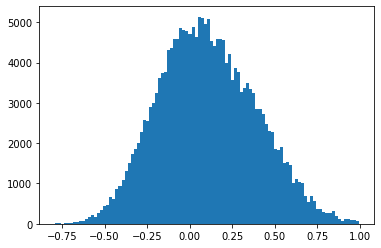

In [41]:
_ = plt.hist(analysis.all_correlations(Yp), bins=100)

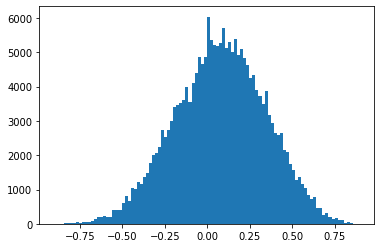

In [42]:
_ = plt.hist(analysis.all_correlations(Yp, spearmanr=True), bins=100)

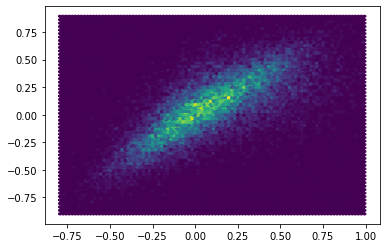

In [43]:
_ = plt.hexbin(analysis.all_correlations(Yp), analysis.all_correlations(Yp, spearmanr=True))

# Plot Tuning Curves

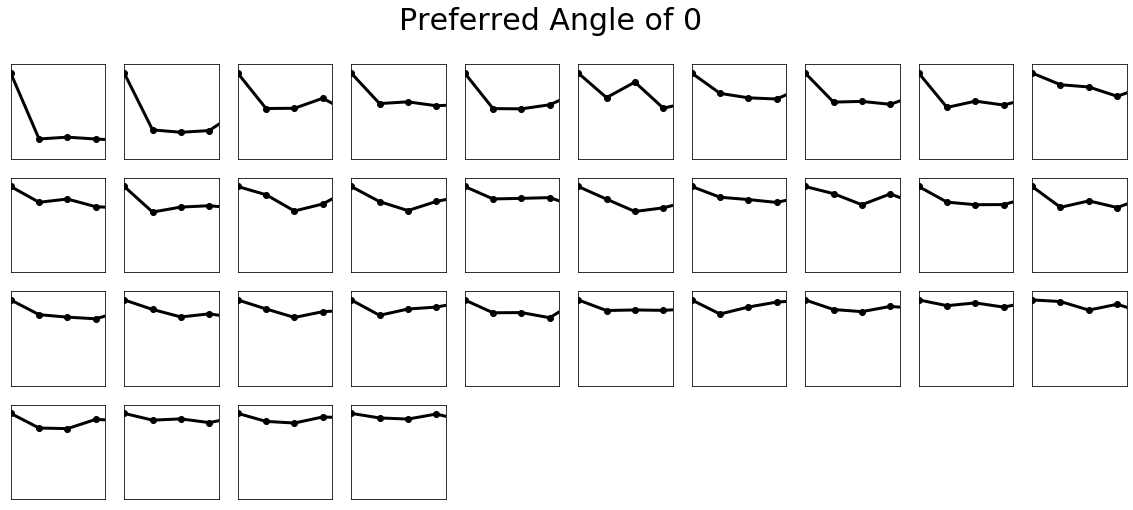

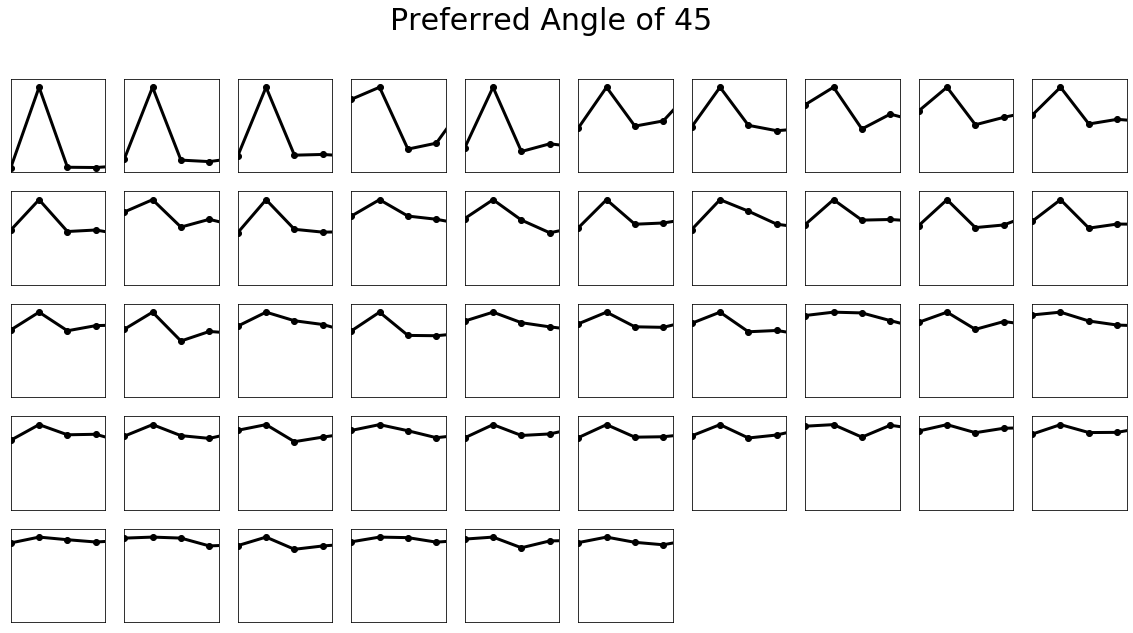

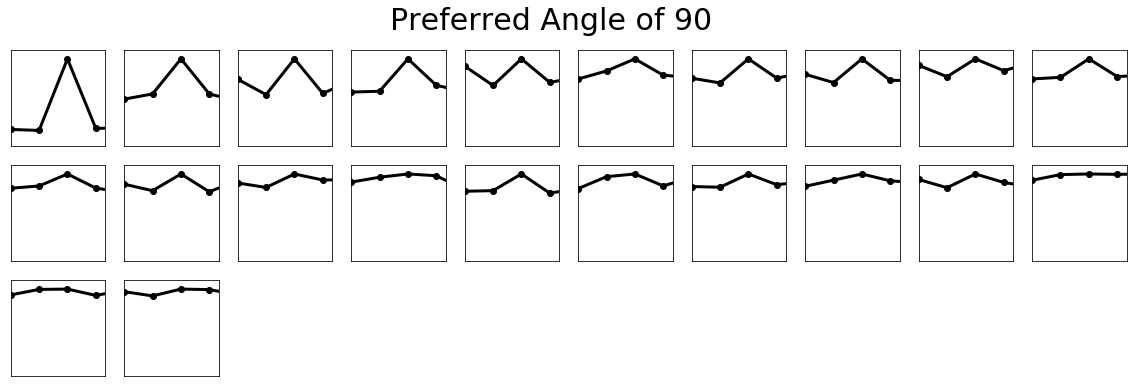

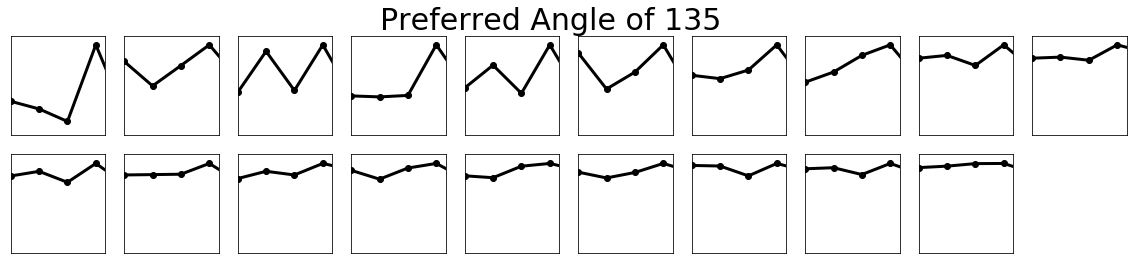

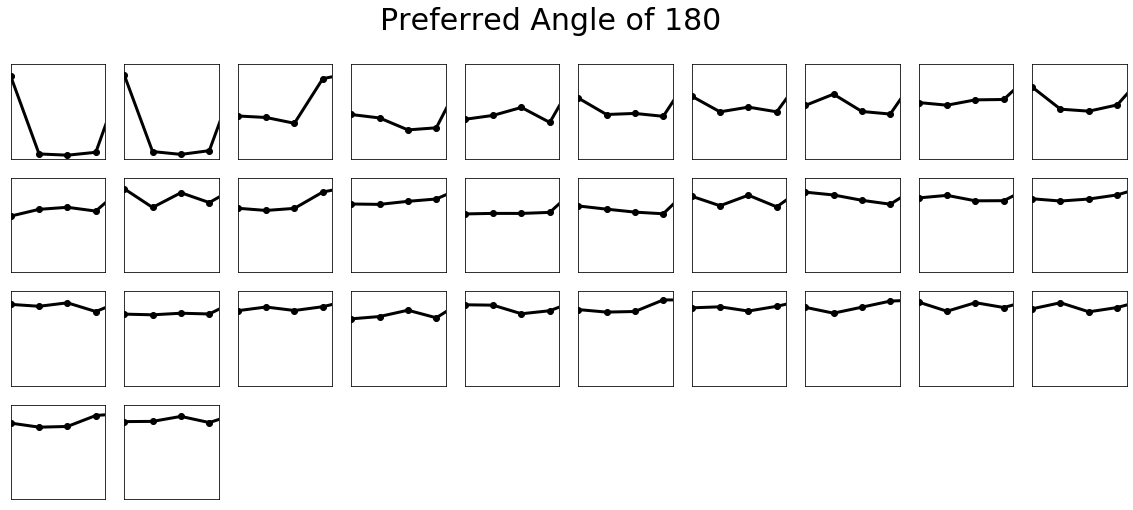

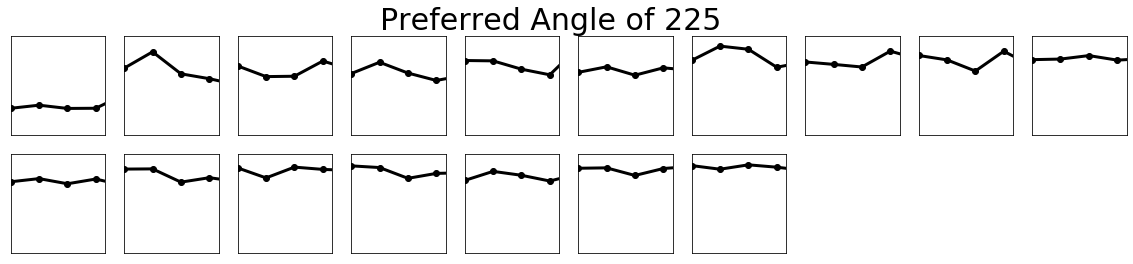

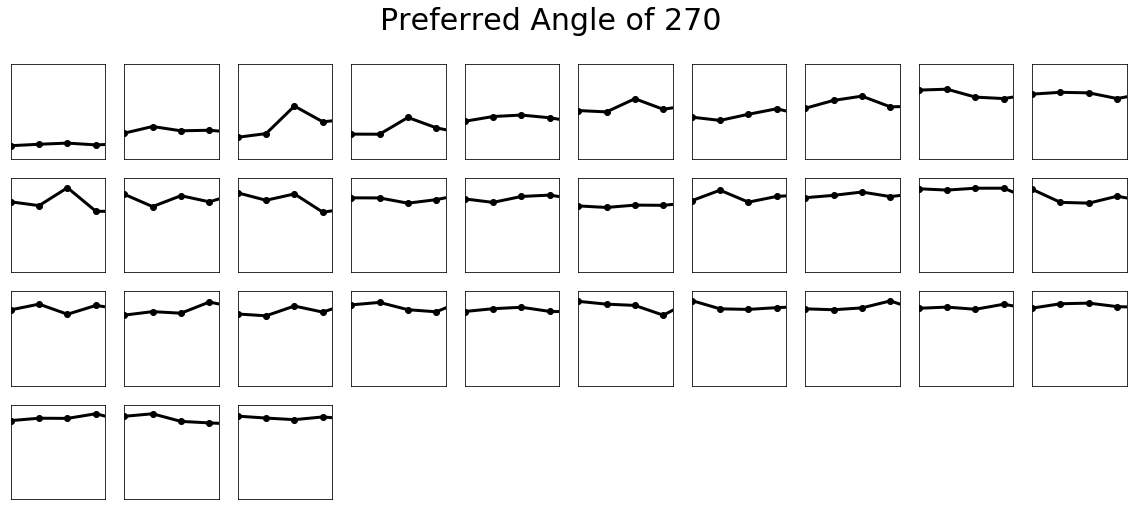

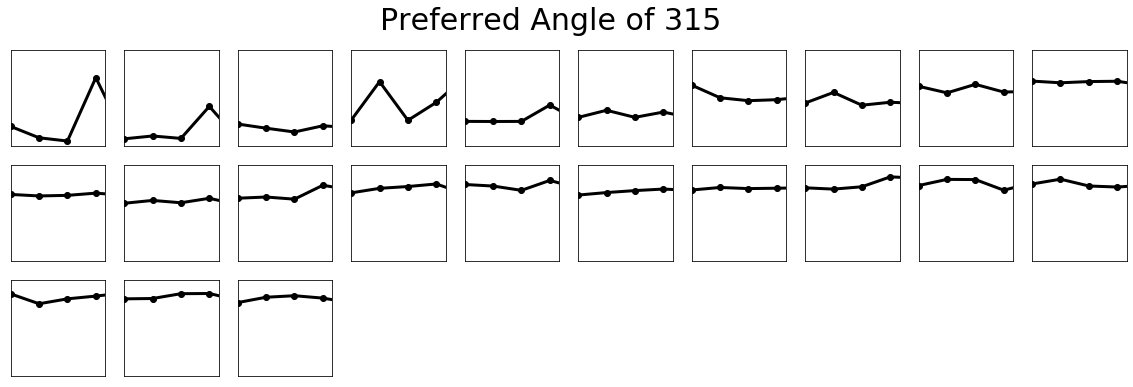

In [44]:
for angle in unique_angles:
    neurons_for_angle = neurons_by_tuning[angle]
    n_neurons_for_angle = neurons_for_angle.size
    
    n_cols = 10
    n_rows = np.ceil(n_neurons_for_angle / n_cols).astype('int')
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))
    
    for idx, ax in enumerate(axes.ravel()):
        if idx < n_neurons_for_angle:
            neuron_idx = neurons_for_angle[idx]
            tuning_curve = tuning_curves[neuron_idx]
            ax.plot(unique_angles, tuning_curve / np.max(tuning_curve),
                    marker='o', color='k', linewidth=3)
            ax.set_ylim(0, 1.1)
            ax.set_xlim([0, 150])
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
    
    fig.suptitle('Preferred Angle of ' + str(int(angle)), fontsize=30)
    plt.savefig('allen_tuning_curves_' + str(int(angle)) + '.pdf', bbox_inches='tight')
    

# Plot Neuron-Neuron Responses

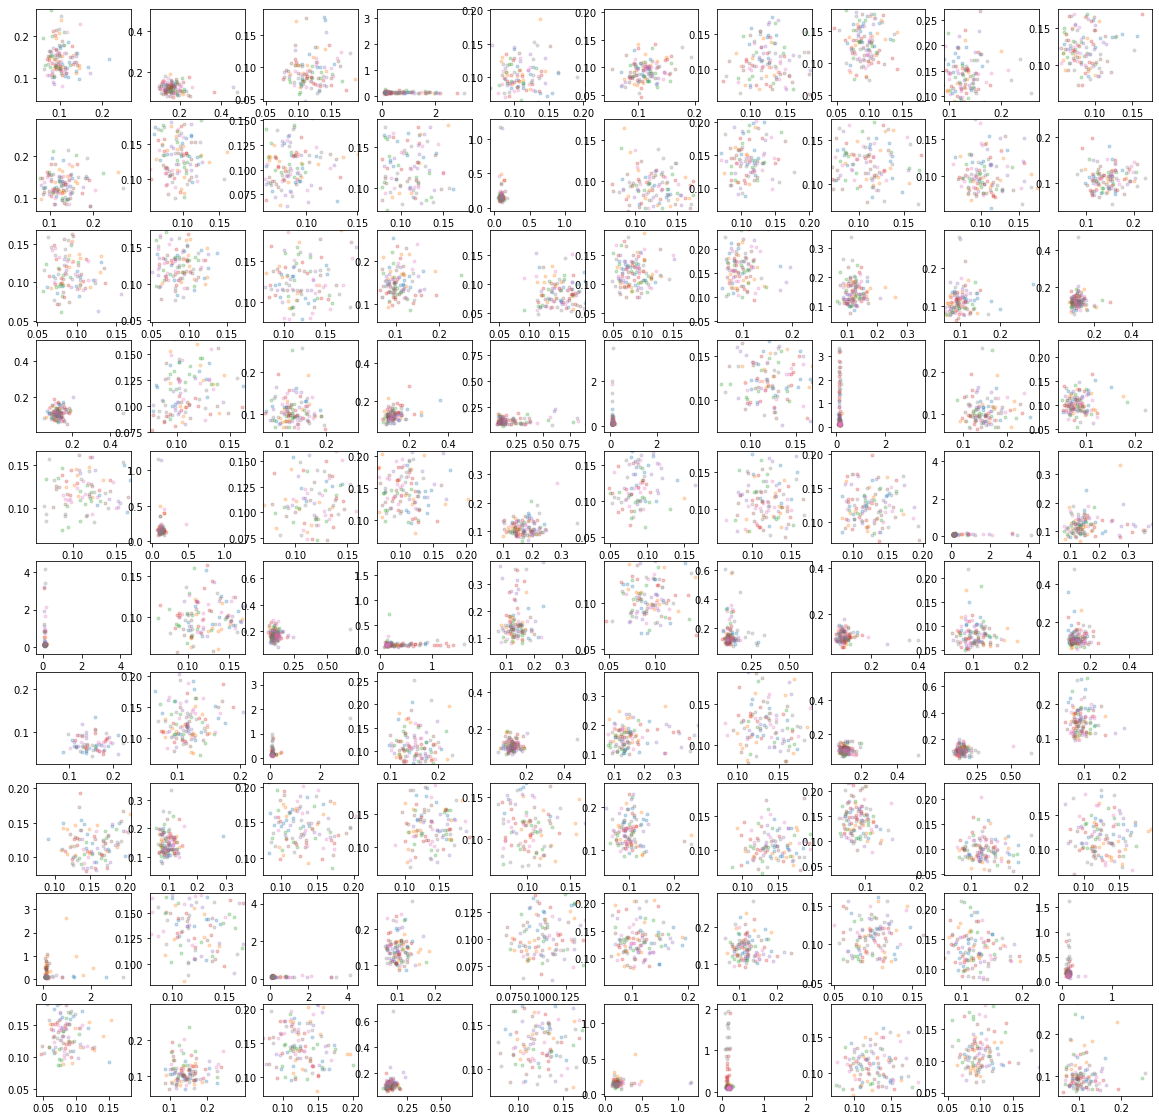

In [45]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

for ax in axes.ravel():
    n0, n1 = np.random.permutation(Y.shape[1])[:2]
    for angle in sorted(set(angles)):
        angle_idx = np.argwhere(angles == angle).ravel()
        y0 = Y[angle_idx, n0]
        y1 = Y[angle_idx, n1]
        minval = min(y0.min(), y1.min())
        maxval = max(y0.max(), y1.max())
        diff = maxval - minval
        ax.scatter(y0, y1, alpha=0.25, marker='.')
        ax.set_xlim(minval - .1 *diff, maxval + .1 *diff)
        ax.set_ylim(minval - .1 *diff, maxval + .1 *diff)

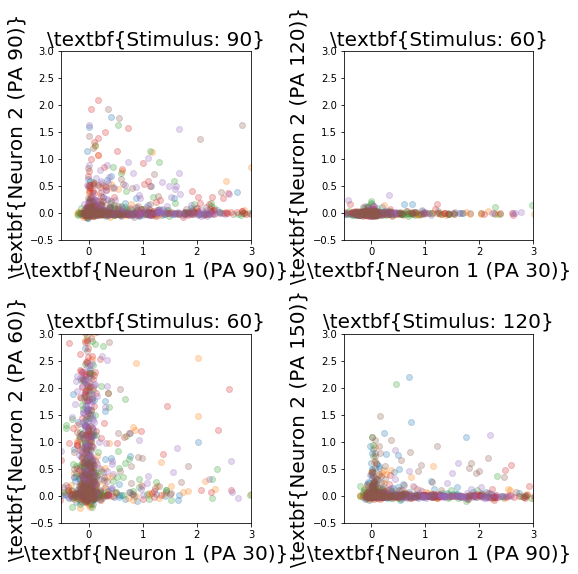

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# similar neurons
neuron1 = neurons_by_tuning[90][0]
neuron2 = neurons_by_tuning[90][1]

for angle in [0, 30, 60, 90, 120, 150]:
    angle_idx = np.argwhere(angles == angle).ravel()
    axes[0, 0].scatter(
        Y[angle_idx, neuron1], Y[angle_idx, neuron2], alpha=0.25)
axes[0, 0].set_xlim([-0.5, 3])
axes[0, 0].set_ylim([-0.5, 3])
axes[0, 0].set_xlabel(r'\textbf{Neuron 1 (PA 90)}', fontsize=20)
axes[0, 0].set_ylabel(r'\textbf{Neuron 2 (PA 90)}', fontsize=20)
axes[0, 0].set_title(r'\textbf{Stimulus: 90}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[30][0]
neuron2 = neurons_by_tuning[120][5]

for angle in [0, 30, 60, 90, 120, 150]:
    angle_idx = np.argwhere(angles == angle).ravel()
    axes[0, 1].scatter(
        Y[angle_idx, neuron1], Y[angle_idx, neuron2], alpha=0.25)
axes[0, 1].set_xlim([-0.5, 3])
axes[0, 1].set_ylim([-0.5, 3])
axes[0, 1].set_xlabel(r'\textbf{Neuron 1 (PA 30)}', fontsize=20)
axes[0, 1].set_ylabel(r'\textbf{Neuron 2 (PA 120)}', fontsize=20)
axes[0, 1].set_title(r'\textbf{Stimulus: 60}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[30][0]
neuron2 = neurons_by_tuning[90][0]

for angle in [0, 30, 60, 90, 120, 150]:
    angle_idx = np.argwhere(angles == angle).ravel()
    axes[1, 0].scatter(
        Y[angle_idx, neuron1], Y[angle_idx, neuron2], alpha=0.25)
axes[1, 0].set_xlim([-0.5, 3])
axes[1, 0].set_ylim([-0.5, 3])
axes[1, 0].set_xlabel(r'\textbf{Neuron 1 (PA 30)}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{Neuron 2 (PA 60)}', fontsize=20)
axes[1, 0].set_title(r'\textbf{Stimulus: 60}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[90][0]
neuron2 = neurons_by_tuning[150][0]

for angle in [0, 30, 60, 90, 120, 150]:
    angle_idx = np.argwhere(angles == angle).ravel()
    axes[1, 1].scatter(
        Y[angle_idx, neuron1], Y[angle_idx, neuron2], alpha=0.25)
axes[1, 1].set_xlim([-0.5, 3])
axes[1, 1].set_ylim([-0.5, 3])
axes[1, 1].set_xlabel(r'\textbf{Neuron 1 (PA 90)}', fontsize=20)
axes[1, 1].set_ylabel(r'\textbf{Neuron 2 (PA 150)}', fontsize=20)
axes[1, 1].set_title(r'\textbf{Stimulus: 120}', fontsize=20)

for ax in axes.ravel():
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('allen_paired_responses.pdf', bbox_inches='tight')

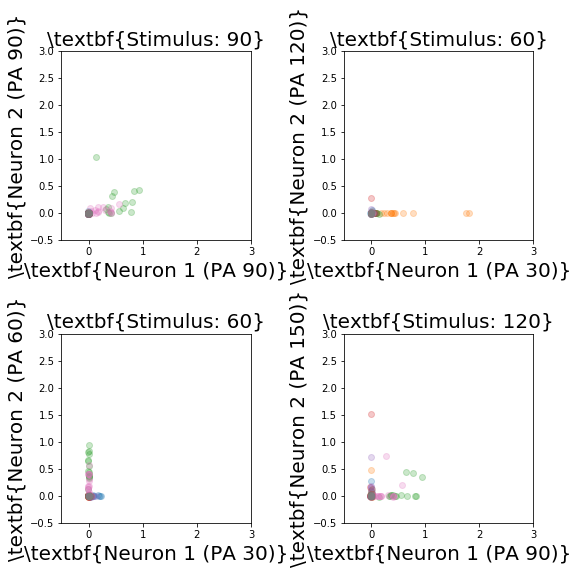

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# similar neurons
neuron1 = neurons_by_tuning[90][0]
neuron2 = neurons_by_tuning[90][1]

for angle in [0, 45, 90, 135, 180, 225, 270, 315]:
    angle_idx = np.argwhere(angles == angle).ravel()
    axes[0, 0].scatter(
        Y[angle_idx, neuron1], Y[angle_idx, neuron2], alpha=0.25)
axes[0, 0].set_xlim([-0.5, 3])
axes[0, 0].set_ylim([-0.5, 3])
axes[0, 0].set_xlabel(r'\textbf{Neuron 1 (PA 90)}', fontsize=20)
axes[0, 0].set_ylabel(r'\textbf{Neuron 2 (PA 90)}', fontsize=20)
axes[0, 0].set_title(r'\textbf{Stimulus: 90}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[45][0]
neuron2 = neurons_by_tuning[135][5]

for angle in [0, 45, 90, 135, 180, 225, 270, 315]:
    angle_idx = np.argwhere(angles == angle).ravel()
    axes[0, 1].scatter(
        Y[angle_idx, neuron1], Y[angle_idx, neuron2], alpha=0.25)
axes[0, 1].set_xlim([-0.5, 3])
axes[0, 1].set_ylim([-0.5, 3])
axes[0, 1].set_xlabel(r'\textbf{Neuron 1 (PA 30)}', fontsize=20)
axes[0, 1].set_ylabel(r'\textbf{Neuron 2 (PA 120)}', fontsize=20)
axes[0, 1].set_title(r'\textbf{Stimulus: 60}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[0][0]
neuron2 = neurons_by_tuning[90][0]

for angle in [0, 45, 90, 135, 180, 225, 270, 315]:
    angle_idx = np.argwhere(angles == angle).ravel()
    axes[1, 0].scatter(
        Y[angle_idx, neuron1], Y[angle_idx, neuron2], alpha=0.25)
axes[1, 0].set_xlim([-0.5, 3])
axes[1, 0].set_ylim([-0.5, 3])
axes[1, 0].set_xlabel(r'\textbf{Neuron 1 (PA 30)}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{Neuron 2 (PA 60)}', fontsize=20)
axes[1, 0].set_title(r'\textbf{Stimulus: 60}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[90][0]
neuron2 = neurons_by_tuning[135][0]

for angle in [0, 45, 90, 135, 180, 225, 270, 315]:
    angle_idx = np.argwhere(angles == angle).ravel()
    axes[1, 1].scatter(
        Y[angle_idx, neuron1], Y[angle_idx, neuron2], alpha=0.25)
axes[1, 1].set_xlim([-0.5, 3])
axes[1, 1].set_ylim([-0.5, 3])
axes[1, 1].set_xlabel(r'\textbf{Neuron 1 (PA 90)}', fontsize=20)
axes[1, 1].set_ylabel(r'\textbf{Neuron 2 (PA 150)}', fontsize=20)
axes[1, 1].set_title(r'\textbf{Stimulus: 120}', fontsize=20)

for ax in axes.ravel():
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('allen_paired_responses.pdf', bbox_inches='tight')

In [60]:
set(angles)

{0.0, 30.0, 60.0, 90.0, 120.0, 150.0}

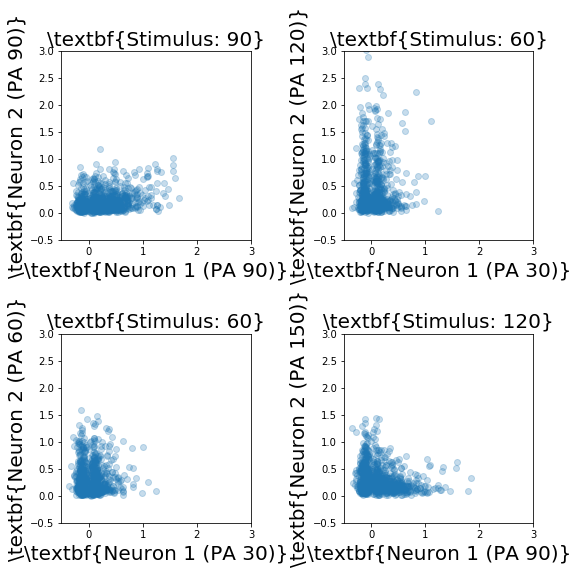

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# similar neurons
neuron1 = neurons_by_tuning[90][0]
neuron2 = neurons_by_tuning[90][1]

angle_idx = np.argwhere(angles == 90).ravel()
axes[0, 0].scatter(
    np.sign(Y[angle_idx, neuron1]) * np.sqrt(np.abs(Y[angle_idx, neuron1])),
    np.sign(np.abs(Y[angle_idx, neuron2])) * np.sqrt(np.abs(Y[angle_idx, neuron2])),
    alpha=0.25)
axes[0, 0].set_xlim([-0.5, 3])
axes[0, 0].set_ylim([-0.5, 3])
axes[0, 0].set_xlabel(r'\textbf{Neuron 1 (PA 90)}', fontsize=20)
axes[0, 0].set_ylabel(r'\textbf{Neuron 2 (PA 90)}', fontsize=20)
axes[0, 0].set_title(r'\textbf{Stimulus: 90}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[30][0]
neuron2 = neurons_by_tuning[120][0]

angle_idx = np.argwhere(angles == 60).ravel()
axes[0, 1].scatter(
    np.sign(Y[angle_idx, neuron1]) * np.sqrt(np.abs(Y[angle_idx, neuron1])),
    np.sign(np.abs(Y[angle_idx, neuron2])) * np.sqrt(np.abs(Y[angle_idx, neuron2])),
    alpha=0.25)
axes[0, 1].set_xlim([-0.5, 3])
axes[0, 1].set_ylim([-0.5, 3])
axes[0, 1].set_xlabel(r'\textbf{Neuron 1 (PA 30)}', fontsize=20)
axes[0, 1].set_ylabel(r'\textbf{Neuron 2 (PA 120)}', fontsize=20)
axes[0, 1].set_title(r'\textbf{Stimulus: 60}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[30][0]
neuron2 = neurons_by_tuning[60][0]

angle_idx = np.argwhere(angles == 60).ravel()
axes[1, 0].scatter(
    np.sign(Y[angle_idx, neuron1]) * np.sqrt(np.abs(Y[angle_idx, neuron1])),
    np.sign(np.abs(Y[angle_idx, neuron2])) * np.sqrt(np.abs(Y[angle_idx, neuron2])),
    alpha=0.25)
axes[1, 0].set_xlim([-0.5, 3])
axes[1, 0].set_ylim([-0.5, 3])
axes[1, 0].set_xlabel(r'\textbf{Neuron 1 (PA 30)}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{Neuron 2 (PA 60)}', fontsize=20)
axes[1, 0].set_title(r'\textbf{Stimulus: 60}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[90][0]
neuron2 = neurons_by_tuning[150][0]

angle_idx = np.argwhere(angles == 120).ravel()
axes[1, 1].scatter(
    np.sign(Y[angle_idx, neuron1]) * np.sqrt(np.abs(Y[angle_idx, neuron1])),
    np.sign(np.abs(Y[angle_idx, neuron2])) * np.sqrt(np.abs(Y[angle_idx, neuron2])),
    alpha=0.25)
axes[1, 1].set_xlim([-0.5, 3])
axes[1, 1].set_ylim([-0.5, 3])
axes[1, 1].set_xlabel(r'\textbf{Neuron 1 (PA 90)}', fontsize=20)
axes[1, 1].set_ylabel(r'\textbf{Neuron 2 (PA 150)}', fontsize=20)
axes[1, 1].set_title(r'\textbf{Stimulus: 120}', fontsize=20)

for ax in axes.ravel():
    ax.set_aspect('equal')

    
plt.tight_layout()
plt.savefig('allen_paired_responses_sqrt.pdf', bbox_inches='tight')

In [17]:
Y_new = Y - np.min(Y, axis=0, keepdims=True)

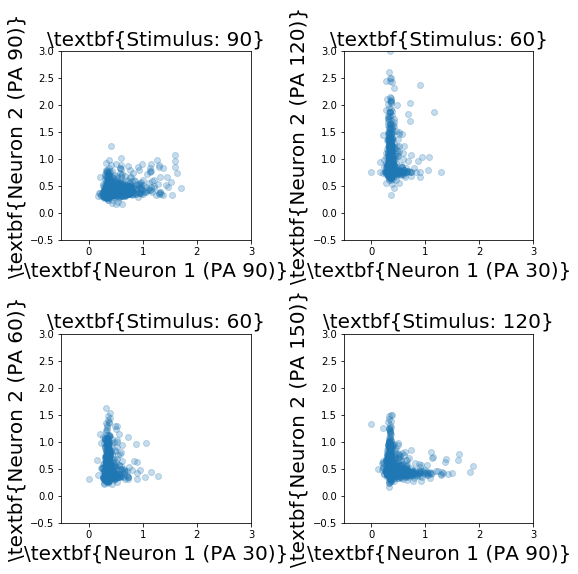

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# similar neurons
neuron1 = neurons_by_tuning[90][0]
neuron2 = neurons_by_tuning[90][1]

angle_idx = np.argwhere(angles == 90).ravel()
axes[0, 0].scatter(
    np.sqrt(Y_new[angle_idx, neuron1]),
    np.sqrt(Y_new[angle_idx, neuron2]),
    alpha=0.25)
axes[0, 0].set_xlim([-0.5, 3])
axes[0, 0].set_ylim([-0.5, 3])
axes[0, 0].set_xlabel(r'\textbf{Neuron 1 (PA 90)}', fontsize=20)
axes[0, 0].set_ylabel(r'\textbf{Neuron 2 (PA 90)}', fontsize=20)
axes[0, 0].set_title(r'\textbf{Stimulus: 90}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[30][0]
neuron2 = neurons_by_tuning[120][0]

angle_idx = np.argwhere(angles == 60).ravel()
axes[0, 1].scatter(
    np.sqrt(Y_new[angle_idx, neuron1]),
    np.sqrt(Y_new[angle_idx, neuron2]),
    alpha=0.25)
axes[0, 1].set_xlim([-0.5, 3])
axes[0, 1].set_ylim([-0.5, 3])
axes[0, 1].set_xlabel(r'\textbf{Neuron 1 (PA 30)}', fontsize=20)
axes[0, 1].set_ylabel(r'\textbf{Neuron 2 (PA 120)}', fontsize=20)
axes[0, 1].set_title(r'\textbf{Stimulus: 60}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[30][0]
neuron2 = neurons_by_tuning[60][0]

angle_idx = np.argwhere(angles == 60).ravel()
axes[1, 0].scatter(
    np.sqrt(Y_new[angle_idx, neuron1]),
    np.sqrt(Y_new[angle_idx, neuron2]),
    alpha=0.25)
axes[1, 0].set_xlim([-0.5, 3])
axes[1, 0].set_ylim([-0.5, 3])
axes[1, 0].set_xlabel(r'\textbf{Neuron 1 (PA 30)}', fontsize=20)
axes[1, 0].set_ylabel(r'\textbf{Neuron 2 (PA 60)}', fontsize=20)
axes[1, 0].set_title(r'\textbf{Stimulus: 60}', fontsize=20)

# different neurons
neuron1 = neurons_by_tuning[90][0]
neuron2 = neurons_by_tuning[150][0]

angle_idx = np.argwhere(angles == 120).ravel()
axes[1, 1].scatter(
    np.sqrt(Y_new[angle_idx, neuron1]),
    np.sqrt(Y_new[angle_idx, neuron2]),
    alpha=0.25)
axes[1, 1].set_xlim([-0.5, 3])
axes[1, 1].set_ylim([-0.5, 3])
axes[1, 1].set_xlabel(r'\textbf{Neuron 1 (PA 90)}', fontsize=20)
axes[1, 1].set_ylabel(r'\textbf{Neuron 2 (PA 150)}', fontsize=20)
axes[1, 1].set_title(r'\textbf{Stimulus: 120}', fontsize=20)

for ax in axes.ravel():
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('allen_paired_responses_sqrt_offset.pdf', bbox_inches='tight')

In [36]:
stimulus_name = 'static_gratings'
ophys_experiment_id = allen.get_ophys_experiment_id(experiment_id=experiment_id, stimulus_name=stimulus_name)
data = allen.boc.get_ophys_experiment_data(ophys_experiment_id)

In [37]:
times, dffs = data.get_dff_traces()
table = data.get_stimulus_table(stimulus_name)
starts = table['start'].values
ends = table['end'].values

(0, 500)

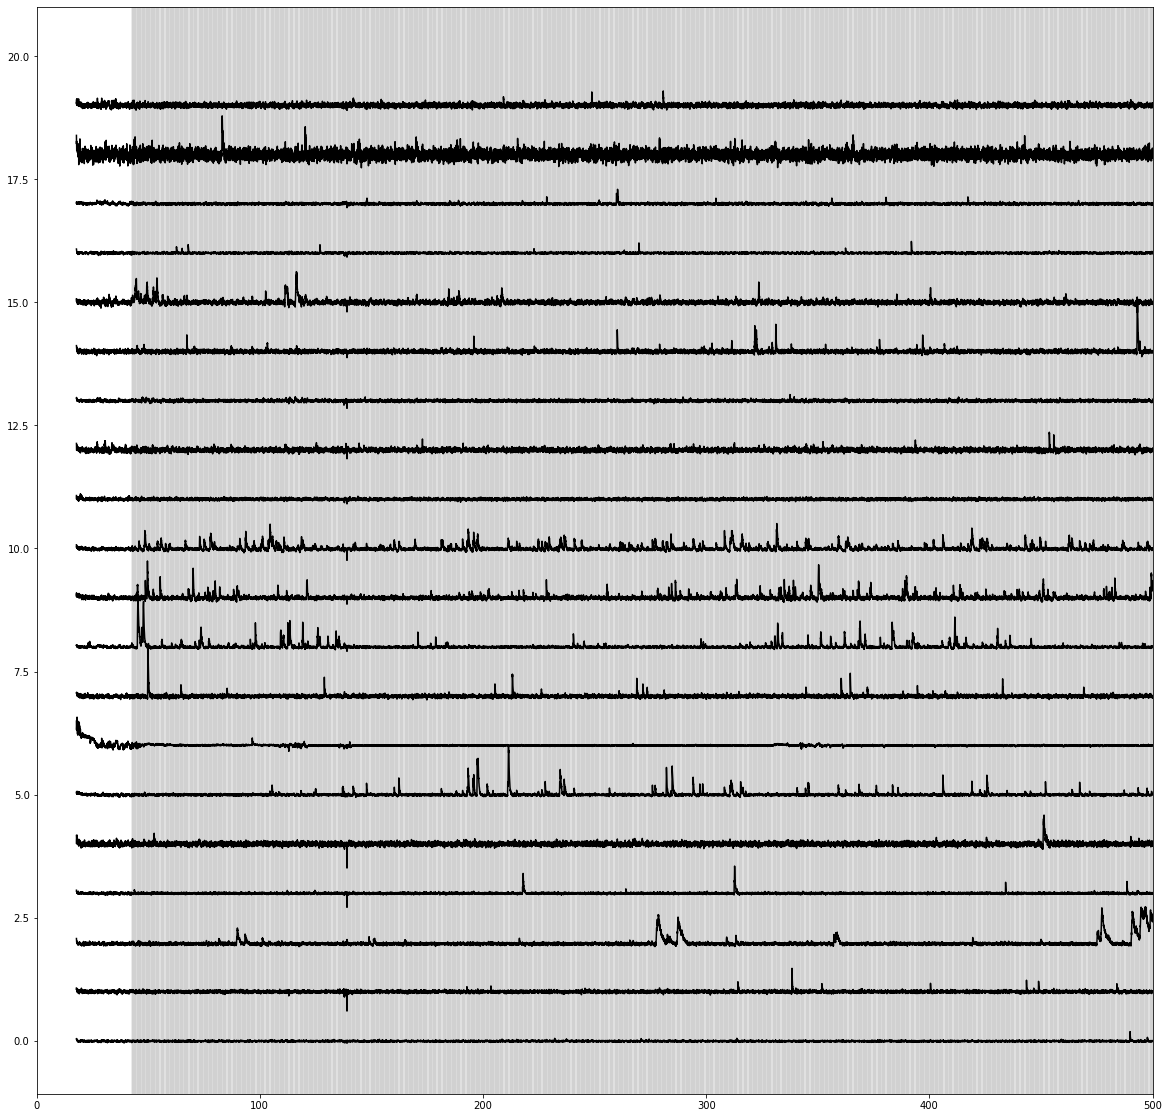

In [40]:
plt.figure(figsize=(20, 20))
for ii in range(20):
    y = dffs[ii]
    y = y - y.mean()
    y = y / abs(y).max()
    plt.plot(times,  y + ii, c='k')
for st, et in zip(starts, ends):
    plt.axvspan(times[st], times[et], color='gray', alpha=.1)
plt.xlim(0, 500)

In [39]:
table

,orientation,spatial_frequency,phase,start,end
0,120.0,0.32,0.00,737,744
1,120.0,0.16,0.00,745,752
2,30.0,0.04,0.00,752,759
3,90.0,0.32,0.00,760,767
4,120.0,0.08,0.25,767,774
...,...,...,...,...,...
5995,150.0,0.08,0.75,113847,113854
5996,120.0,0.02,0.50,113855,113862
5997,60.0,0.32,0.00,113862,113869
5998,90.0,0.32,0.50,113870,113877
